In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


# Explore the data set

Number of training examples: 60000
Number of testing examples: 10000
Number of classes: 10
Image shape: (28, 28)
Image data type: uint8


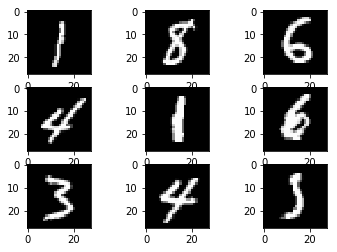

In [3]:
for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 123], cmap="gray")
num_classes = np.unique(y_train).shape[0]
print("Number of training examples:", x_train.shape[0])
print("Number of testing examples:", x_test.shape[0])
print("Number of classes:", num_classes)
print("Image shape:", x_train[0].shape)
print("Image data type:", x_train.dtype)

The data set consists of 60000 training examples and 10000 test examples. The data is 28x28 grayscale images of digits from 0-9, giving 10 classes.


<BarContainer object of 10 artists>

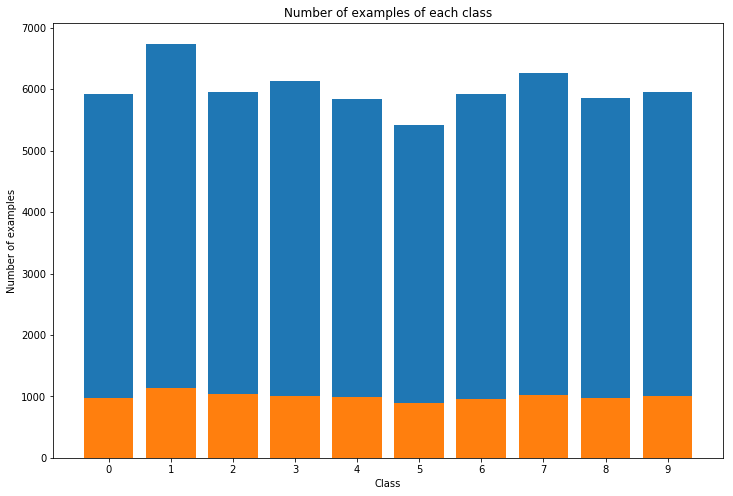

In [4]:
class_distribution_train = Counter(y_train)
class_distribution_test = Counter(y_test)
x = range(10)
train_y = [class_distribution_train[cls] for cls in x]
test_y = [class_distribution_test[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of examples of each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, train_y)
plt.bar(x, test_y)

The class distribution in the data set is fairly even, with a slight weight on the number 1, but this is probably because it is the most difficult number to recognize, as it contains few key features and can be written in several different ways.
The class distribution in the test set is representative of the distribution in the training set.

### Data pre-processing
#### Normalization of the data
We normalize the becuase we want all of the data to be in the same scale. The reason for this is that we want the values of each activation to be in the same range, since we are using gradient descent and multiplying by a learning rate. If we don't do this, the gradients could get really big values and oscillate between different values instead of descending to a minima, which also could happen if we use a learning rate which is too high. 

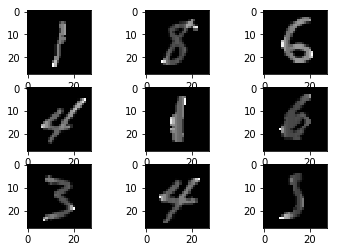

In [5]:
# Normalize the training data
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 123], cmap="gray")


## A note about data augmentation
We decided data augmentation was superfluous for this dataset due to it's simplicity. Hand written digits are usually written in the same orientation, and all of the numbers appear to be fairly centralized. Mirroring the images would obviously give a wrong result, and our model will only run on digits from the same data set, of which the test set is representative. This combined with the fact that our models are simplistic with few parameters, data augmentation would not yield any improvements, conversely, performing augmentation might even induce worse performance if varying too much from the standard format of the numbers.

#### Split training data into training and validation

In [6]:
train_val_split = 0.9 # Percentage of data to use in training set
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split * x_train.shape[0])]
idx_val = indexes[int(train_val_split * x_train.shape[0]):]

x_val = x_train[idx_val]
y_val = y_train[idx_val]

x_train = x_train[idx_train]
y_train = y_train[idx_train]

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Testing set shape:", x_test.shape)

Training set shape: (54000, 28, 28)
Validation set shape: (6000, 28, 28)
Testing set shape: (10000, 28, 28)


## Training the model
Number of epochs is how many times each sample will be fed through the network. We have chosen 10 epochs. The optimal number of epochs is usually found by finding out when the model is unable to train any better, and it is starting to overfit.

Batch size is how many samples we will feed through the network before we update the weights. Having a small batch could be beneficial both because you update the weights more often and because you consume less memory. The downside of small batch sizes is that calculated gradient will be less accurate, and oscillate much more.

Adam is a popular optimizer, because it works well. We experimented with using other optimizers such as SGD but this gave no improvements.

In [7]:
class TrainingParams:
    epochs = 10
    batch_size = 128
    optimizer = 'adam'
    loss = 'sparse_categorical_crossentropy'
    verbose = 1
    metrics = ['accuracy']
training_params = TrainingParams()

In [57]:
def train_model(model_spec, training_parameters):
    model = keras.models.Sequential()
    model_spec(model)
    model.compile(optimizer=training_parameters.optimizer,
                  loss=training_parameters.loss,
                  metrics=training_parameters.metrics)

    model.fit(x_train, y_train,
              validation_data=(x_val, y_val),
              batch_size=training_parameters.batch_size,
              verbose=training_parameters.verbose,
              epochs=training_parameters.epochs)  # train the model

    return model

## Evaluate the model
Helper functions to visualize and evaluete both the model and the training results

In [56]:
def evaluate_model(model):
    model.summary()
    # evaluate the model using the test data
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("Test loss: %.4f, accuracy: %.4f" % (test_loss, test_acc))

def visualize_loss_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_loss"], label="Validation loss")
    plt.plot(history["loss"], label="Training loss")
    plt.legend()

def visualize_accuracy_history(model):
    history = model.history.history
    plt.figure(figsize=(12, 8))
    plt.plot(history["val_acc"], label="Validation accuracy")
    plt.plot(history["acc"], label="Training accuracy")
    plt.legend()

## Models

#### Model 1:
Implementation of the model in table 1¶

| Layer Type | Hidden Units | Activation |
|------------|--------------|------------|
| Dense      | 128          | ReLU       |
| Dense      | 10           | SoftMax    |

In [10]:
def model_1(model):
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))

In [51]:
model = train_model(model_1, training_params)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 1s 26us/step - loss: 0.4588 - acc: 0.8817 - val_loss: 0.2545 - val_acc: 0.9303
Epoch 2/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.2182 - acc: 0.9374 - val_loss: 0.1970 - val_acc: 0.9455
Epoch 3/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.1653 - acc: 0.9528 - val_loss: 0.1686 - val_acc: 0.9522
Epoch 4/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.1311 - acc: 0.9622 - val_loss: 0.1443 - val_acc: 0.9585
Epoch 5/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.1086 - acc: 0.9685 - val_loss: 0.1267 - val_acc: 0.9628
Epoch 6/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.0914 - acc: 0.9732 - val_loss: 0.1213 - val_acc: 0.9653
Epoch 7/10
54000/54000 [==============================] - 1s 22us/step - loss: 0.0786 - acc: 0.9774 - val_loss: 0.1093 - val_acc:

In [56]:
evaluate_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 24us/step
Test loss: 0.0945, accuracy: 0.9722


#### Model 2:
The simplest network which achieves over 95% accuracy. It does only have 12.730 trainable params.

| Layer Type | Hidden Units | Activation |
|------------|--------------|------------|
| Dense      | 16           | ReLU       |
| Dense      | 10           | SoftMax    |
We decided to start with model 1, which scored over 97%, and reduced the number of parameters as low as we could get it while still staying over 95%.


In [17]:
def model_2(model):
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(16, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
training_params.epochs = 28
model = train_model(model_2, training_params)

Train on 54000 samples, validate on 6000 samples
Epoch 1/28
54000/54000 [==============================] - 2s 31us/step - loss: 0.8508 - acc: 0.7754 - val_loss: 0.4255 - val_acc: 0.8805
Epoch 2/28
54000/54000 [==============================] - 1s 25us/step - loss: 0.3464 - acc: 0.9041 - val_loss: 0.3329 - val_acc: 0.9052
Epoch 3/28
54000/54000 [==============================] - 1s 25us/step - loss: 0.2868 - acc: 0.9195 - val_loss: 0.2965 - val_acc: 0.9155
Epoch 4/28
54000/54000 [==============================] - 1s 25us/step - loss: 0.2543 - acc: 0.9282 - val_loss: 0.2706 - val_acc: 0.9227
Epoch 5/28
54000/54000 [==============================] - 1s 25us/step - loss: 0.2318 - acc: 0.9348 - val_loss: 0.2555 - val_acc: 0.9290
Epoch 6/28
54000/54000 [==============================] - 1s 25us/step - loss: 0.2148 - acc: 0.9384 - val_loss: 0.2443 - val_acc: 0.9287
Epoch 7/28
54000/54000 [==============================] - 1s 25us/step - loss: 0.2014 - acc: 0.9412 - val_loss: 0.2337 - val_acc:

In [38]:
evaluate_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_21 (Dense)             (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 32us/step
Test loss: 0.1602, accuracy: 0.9526


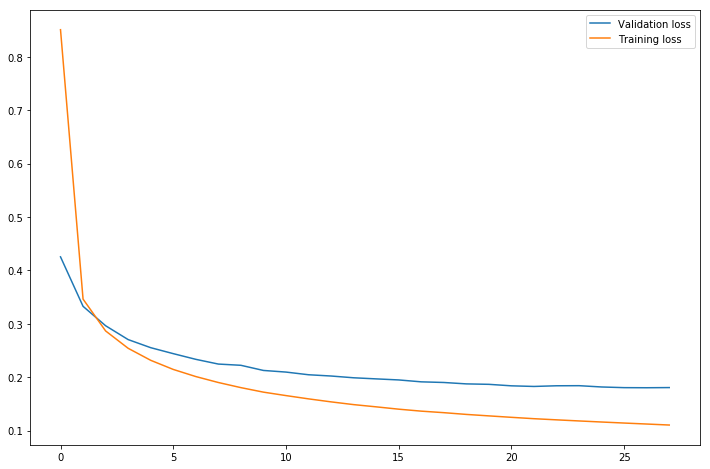

In [39]:
visualize_loss_history(model)

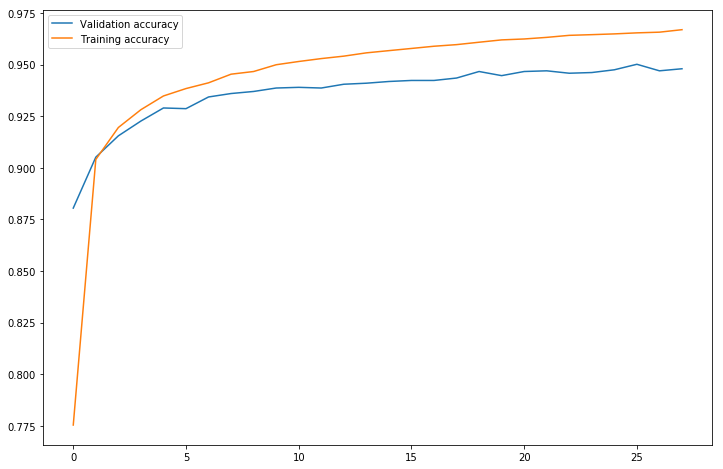

In [41]:
visualize_accuracy_history(model)

We chose to stop training the model after 28 iterations because it was starting to overfit. The model, which consists of only one hidden layer, a dense layer with 16 nodes, yields a 95.26% accuracy on the test set.

In [93]:
def model_3(model):
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(784, activation="relu"))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dropout(0.40))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dense(512, activation="relu"))
    model.add(keras.layers.Dropout(0.50))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.40))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))

In [94]:
training_params.epochs = 30
model = train_model(model_3, training_params)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 8s 143us/step - loss: 0.4405 - acc: 0.8642 - val_loss: 0.1749 - val_acc: 0.9540
Epoch 2/30
54000/54000 [==============================] - 6s 113us/step - loss: 0.1550 - acc: 0.9601 - val_loss: 0.1426 - val_acc: 0.9670
Epoch 3/30
54000/54000 [==============================] - 6s 112us/step - loss: 0.1129 - acc: 0.9717 - val_loss: 0.1301 - val_acc: 0.9672
Epoch 4/30
54000/54000 [==============================] - 6s 116us/step - loss: 0.0847 - acc: 0.9784 - val_loss: 0.1255 - val_acc: 0.9702
Epoch 5/30
54000/54000 [==============================] - 6s 115us/step - loss: 0.0697 - acc: 0.9816 - val_loss: 0.1337 - val_acc: 0.9722
Epoch 6/30
54000/54000 [==============================] - 6s 112us/step - loss: 0.0638 - acc: 0.9842 - val_loss: 0.1212 - val_acc: 0.9742
Epoch 7/30
54000/54000 [==============================] - 6s 115us/step - loss: 0.0481 - acc: 0.9882 - val_loss: 0.1337 - v

In [95]:
evaluate_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 784)               615440    
_________________________________________________________________
dense_121 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_68 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_123 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_69 (Dropout)         (None, 512)               0         
__________

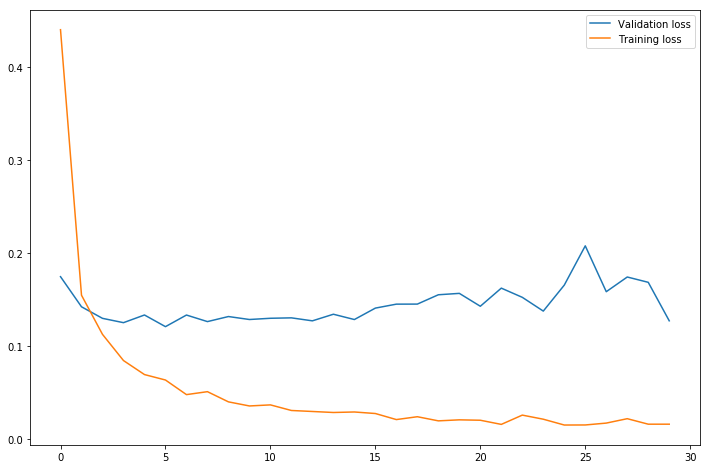

In [96]:
visualize_loss_history(model)

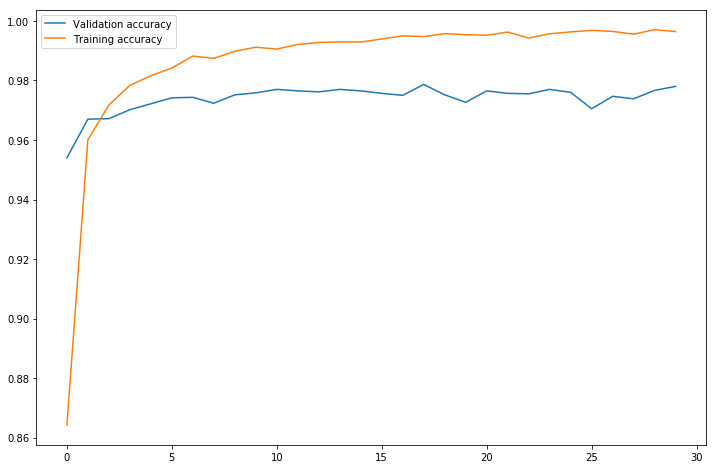

In [97]:
visualize_accuracy_history(model)

## Evaluation of the model
We stopped training the model after 30 epochs because we saw tendencies of overfitting. We also started to get diminishing returns on the increase of accuracy.

We are using a dropout to avoid overfitting. Dropout is working by not conecting a node in the layer with the probability p. This causes the neural network to learn more general features in the images since it does not keep all the connections at a given time during the training phase. Using dropout will also reduce the training time of each epoch, but it takes longer time for the network to converge.

To find the optimal number of layers is a hard problem. If you have too many layers this can cause overfitting, and it would also be more expensive to train the model and classify images. We did not have a great GPU, and needed to take this into consideration. If you on the other hand use too few layers you would often get less accuracy and a high bias. MNIST is however quite an easy problem, so we settled on 11 layers with over 1.7 million trainable parameters. We found this both by testing empirically and by basing it on past experiences. We tried to change both batch size, number of epochs, number of layers and the size of each layer, as well as dropout to get this result.